In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.config.list_physical_devices('GPU'))

2023-08-13 14:09:28.111972: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 14:09:28.156330: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 14:09:28.157805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 14:09:29.243939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


2023-08-13 14:09:31.453010: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
num_classes = 10

In [13]:
inputs = keras.Input(shape =(28,28,1))
x = layers.Conv2D(32,5,strides = (2,2),activation="relu", padding="same")(inputs)
x = layers.Conv2D(32,5,activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(64,3,strides = (2,2), activation = "relu", padding = "same")(x)
x = layers.Conv2D(64,3, activation = "relu", padding = "same")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)


model = keras.Model(inputs,outputs, name = "CNN_MNIST")
model.summary()

Model: "CNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 32)        832       
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        25632     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 32)          0         
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 64)          18496     
                                                         

In [14]:
model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = [keras.metrics.SparseCategoricalAccuracy()]
             )

In [15]:
model.fit(x_train,y_train, epochs = 5, validation_data = [x_test, y_test])

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2840 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.0526 - val_sparse_categorical_accuracy: 0.9832
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.0430 - val_sparse_categorical_accuracy: 0.9885
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0323 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9893
Epoch 5/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.0289 - val_sparse_categorical_accuracy: 0.9922


In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9922


2
313/313 [==============================] - 1s 2ms/step


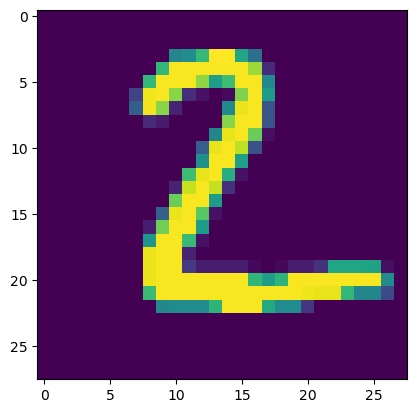

In [32]:
import matplotlib.pyplot as plt
plt.imshow(x_test[1])
print(y_test[1])
prediction = model.predict(x_test)

4


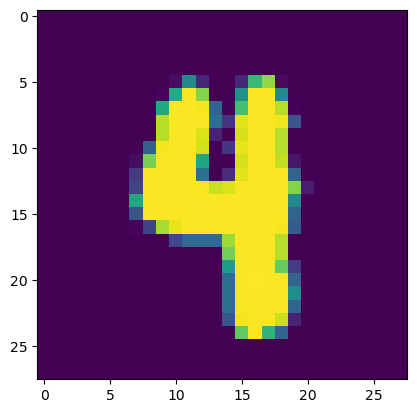

In [35]:
index = 250
plt.imshow(x_test[index])
print(y_test[np.argmax(prediction[index])])

In [37]:
#%% Save model to SavedModel format
tf.saved_model.save(model, "./models/MNIST_model")

 # load the saved_model using low-level API
model_path = "models/MNIST_model"
m = tf.saved_model.load(model_path)

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tfm = tf.function(lambda x: m(x))  # full model                                                  
tfm = tfm.get_concrete_function(tf.TensorSpec(m.signatures['serving_default'].inputs[0].shape.as_list(), m.signatures['serving_default'].inputs[0].dtype.name))   
frozen_func = convert_variables_to_constants_v2(tfm)                                                                                                                              
tf.io.write_graph(graph_or_graph_def=frozen_func.graph, logdir="./", name="MNIST.pb", as_text=False)

INFO:tensorflow:Assets written to: ./models/MNIST_model/assets


INFO:tensorflow:Assets written to: ./models/MNIST_model/assets
2023-08-13 15:48:51.248140: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-08-13 15:48:51.248773: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-08-13 15:48:51.250342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'./MNIST.pb'